# The camera matrix

In [1]:
import numpy as np
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import time
np.random.seed(0)
import itertools

""

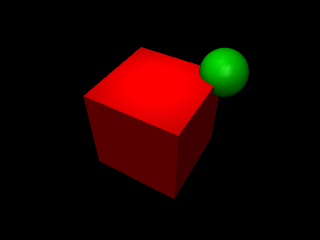

In [2]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [3]:
def compute_camera_matrix(renderer, data):
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.vis.global_.fovy

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

## Project from world to camera coordinates

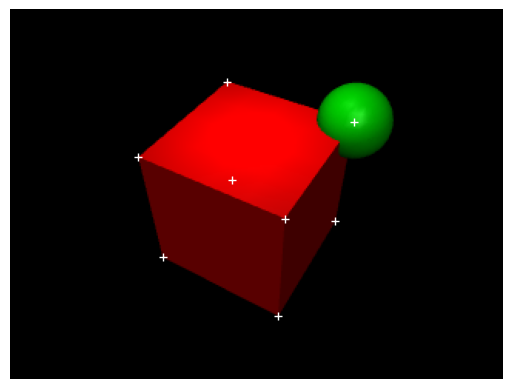

In [4]:
#@title Project from world to camera coordinates {vertical-output: true}
# reset the scene
renderer.update_scene(data)


# Get the world coordinates of the box corners
box_pos = data.geom_xpos[model.geom('red_box').id]
box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
box_size = model.geom_size[model.geom('red_box').id]
offsets = np.array([-1, 1]) * box_size[:, None]
xyz_local = np.stack(list(itertools.product(*offsets))).T
xyz_global = box_pos[:, None] + box_mat @ xyz_local

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Get the camera matrix.
m = compute_camera_matrix(renderer, data)

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = m @ corners_homogeneous
# x and y are in the pixel coordinate system.
x = xs / s
y = ys / s

# Render the camera view and overlay the projected corner coordinates.
pixels = renderer.render()
fig, ax = plt.subplots(1, 1)
ax.imshow(pixels)
ax.plot(x, y, '+', c='w')
ax.set_axis_off()